# Un poco sobre series temporales

#### ¿Qué es una serie de tiempo?

Podemos definir una **serie de tiempo** como un conjunto de observaciones tomadas en **intervalos regulares** que se encuentran **ordenadas** por el momento en que se produjeron.

El análisis de series de tiempo se suele utilizar para proyectar o pronosticar la evolución de una variable a lo largo del tiempo, a partir de información previa sobre esa misma variable. Es decir, tenemos que proyectar una variable determinada (eje y) en función del tiempo (eje x). 

Un ejemplo de serie de tiempo puede ser la evolución del precio de un determinado activo a lo largo del tiempo.






### Descomposición de una serie de tiempo


Existen distintos tipos de modelos para tratar las series de tiempo. 
Una opción es modelar una serie de tiempo como compuesta por **cuatro componentes**:
- **Tendencia**: componente “permanente”, el efecto persiste en el largo plazo. Se puede interpretar como lo que motiva el cambio a largo plazo de la media.
- **Estacionalidad**: esta componente aporta movimientos periódicos a la serie.
- **Ciclos**: se entiende por cualquier tipo de dinámica no capturada por la tendencia o la estacionalidad. Estamos ante la presencia de ciclos cuando observamos algún tipo de dinámica mediante la cual el presente está vinculado al pasado. 
- **Componente aleatoria**: son particularidades que no presentan un efecto duradero, ya que las asumimos con media 0 y varianza constante.

De manera aditiva, podemos decir entonces que: 

$$ y_t = T_t + S_t + C_t + \varepsilon_t. $$

donde T es la tendencia, S es el efecto estacional C es el ciclo y $ \varepsilon $ es el error aleatorio.

#### Tendencia

La **tendencia** corresponde a la **evolución de largo plazo** de la variable que estamos analizando. Puede ser generada por la lenta evolución y cambios en las preferencias, la tecnología, las instituciones o en la demografía.



Podemos modelar la tendencia de diferentes maneras, dependiendo de la dinámica de la tendencia. 

##### Tendencia lineal:

$$ T_t = \beta_0 + \beta_1 TIME_t + \varepsilon_t. $$

Donde la variable *TIME* es una variable que construimos artificialmente, llamada “dummy de tiempo”.

Si la tendencia que estamos buscando modelar presenta una dinámica no lineal, podemos incluir un **término cuadrático** al modelo. Lo obtenemos simplemente elevando al cuadrado a la dummy de tiempo:

$$ T_t = \beta_0 + \beta_1 TIME_t + \beta_2 TIME^{2}_t +\varepsilon_t. $$


Si la tendencia está caracterizada por una tasa de crecimiento constante, podemos usar un **modelo exponencial**:

$$ T_t = \beta_0 e^{\beta_1 TIME_t}\varepsilon_t. $$




#### Estacionalidad

Un **patrón estacional** se repite con regularidad. 

Podemos modelar la estacionalidad utilizando variables dummy. 

Podemos agregar otro tipo de dummies, por ejemplo por días de vacaciones/feriados o ajustes por cantidad de días de comercio, etc.


### Modelos básicos para pronósticos

Pasemos al código para poner estos conceptos en práctica. 

En esta clase vamos a usar series de tiempo para predecir las ventas de medicamentos para diabetes en Australia.


In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

import warnings
warnings.filterwarnings('ignore')


#### Análisis exploratorio y preprocesamiento de los datos:


Creamos nuestro DataFrame y realizamos un ploteo inicial:

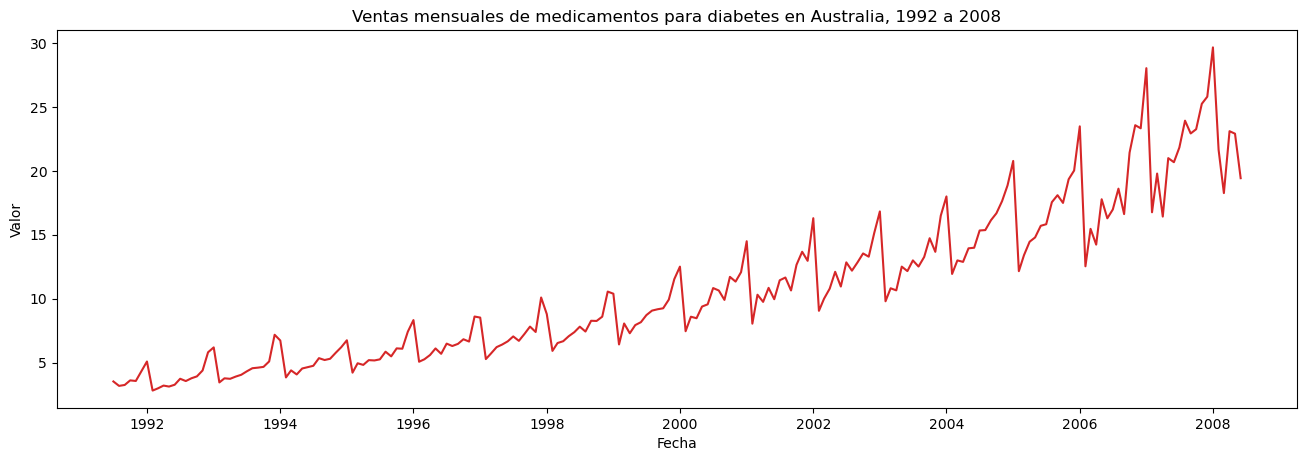

In [15]:
df = pd.read_csv('../Data/a10.csv', parse_dates=['date'], index_col='date')

# Función que plotea la serie:
def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Valor', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value,\
        title='Ventas mensuales de medicamentos para diabetes en Australia, 1992 a 2008')

Exploramos las primeras 5 observaciones de nuestro df:

In [16]:
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


Ploteamos la estacionalidad, la tendencia y el residual como vimos en la teoría.

<Figure size 1440x1152 with 0 Axes>

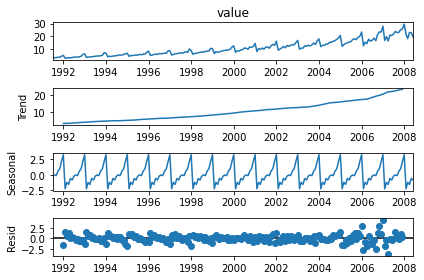

In [23]:
import statsmodels.api as sm
plt.figure(figsize=(20,16))
decomposition = sm.tsa.seasonal_decompose(df['value'], model='additive')
decomposition.plot()
plt.show()

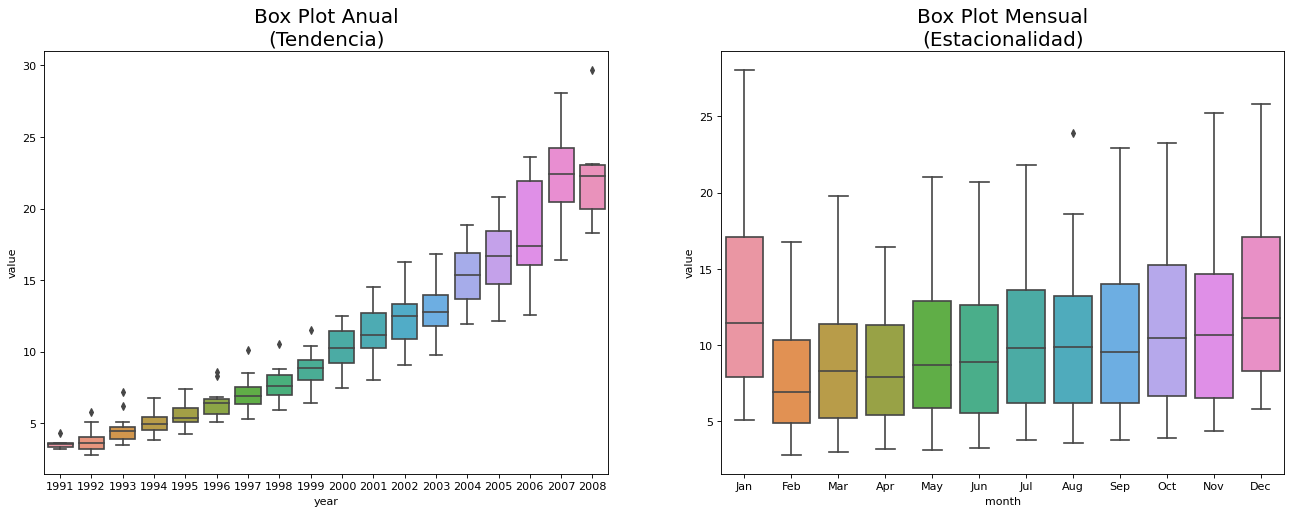

In [18]:
# Definimos los plots:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :])

# Seteamos los títulos:
axes[0].set_title('Box Plot Anual\n(Tendencia)', fontsize=18); 
axes[1].set_title('Box Plot Mensual\n(Estacionalidad)', fontsize=18);

Veamos el shape de nuestro df:

In [19]:
df.shape

(204, 3)

Vamos a crear una **dummy de tiempo**, es decir indicador numérico para el período de tiempo,  para poder modelar la tendencia lineal.

También vamos a crear una variable que sea la dummy de tiempo elevada al cuadrado para modelar la tendencia cuadrática:

In [20]:
df["timeIndex"] = pd.Series(np.arange(len(df['value'])), index=df.index)
df["timeIndex_sq"] = df["timeIndex"]**2

In [21]:
# Creamos variables dummy para los meses:
dummies_mes = pd.get_dummies(df['month'], drop_first=True)
dummies_mes.head()

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
date,,,,,,,,,,,
1991-07-01,0,0,0,0,1,0,0,0,0,0,0
1991-08-01,1,0,0,0,0,0,0,0,0,0,0
1991-09-01,0,0,0,0,0,0,0,0,0,0,1
1991-10-01,0,0,0,0,0,0,0,0,0,1,0
1991-11-01,0,0,0,0,0,0,0,0,1,0,0


In [24]:
# Hacemos el join entre el DataFrame con la serie de tiempo y las dummies:
df = df.join(dummies_mes)
df.sample(5)

,value,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
date,,,,,,,,,,,,,,,,
2008-06-01,19.431740,2008,Jun,203,41209,0,0,0,0,0,1,0,0,0,0,0
2000-02-01,7.457199,2000,Feb,103,10609,0,0,1,0,0,0,0,0,0,0,0
2004-05-01,13.943447,2004,May,154,23716,0,0,0,0,0,0,0,1,0,0,0
1996-02-01,5.069796,1996,Feb,55,3025,0,0,1,0,0,0,0,0,0,0,0
1994-12-01,6.204593,1994,Dec,41,1681,0,1,0,0,0,0,0,0,0,0,0


Vamos a hacer un split entre train y test, teniendo en cuenta que, al tratarse de una serie de tiempo, tenemos que poner *shuffle=False*.

In [26]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=12, random_state=42, shuffle=False)

¿Qué problema generaría hacer el split con shuffle=True?

Verificamos la continuidad entre los sets de entrenamiento y de testeo:

In [27]:
# Vemos los últimos datos del set de entrenamiento:

df_train.tail()

,value,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
date,,,,,,,,,,,,,,,,
2007-02-01,16.763869,2007,Feb,187,34969,0,0,1,0,0,0,0,0,0,0,0
2007-03-01,19.792754,2007,Mar,188,35344,0,0,0,0,0,0,1,0,0,0,0
2007-04-01,16.427305,2007,Apr,189,35721,0,0,0,0,0,0,0,0,0,0,0
2007-05-01,21.000742,2007,May,190,36100,0,0,0,0,0,0,0,1,0,0,0
2007-06-01,20.681002,2007,Jun,191,36481,0,0,0,0,0,1,0,0,0,0,0


In [28]:
# Vemos los primeros datos del set de testeo:

df_test.head()

,value,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
date,,,,,,,,,,,,,,,,
2007-07-01,21.834890,2007,Jul,192,36864,0,0,0,0,1,0,0,0,0,0,0
2007-08-01,23.930204,2007,Aug,193,37249,1,0,0,0,0,0,0,0,0,0,0
2007-09-01,22.930357,2007,Sep,194,37636,0,0,0,0,0,0,0,0,0,0,1
2007-10-01,23.263340,2007,Oct,195,38025,0,0,0,0,0,0,0,0,0,1,0
2007-11-01,25.250030,2007,Nov,196,38416,0,0,0,0,0,0,0,0,1,0,0


Vemos que hay continuidad entre el set de entrenamiento y el de testeo. Podemos entrenar los modelos con datos hasta septiembre de 2006 y testear con datos desde octubre en adelante.

#### Media Constante:

La **media constante** es el modelo más básico e ingenuo de todos. Consiste simplemente en tomar la media del set de entrenamiento y utilizar ese valor para realizar predicciones. Puede usarse como un baseline para comparar otros modelos, pero difícilmente sea nuestro modelo final.

In [29]:
# Calculamos el promedio:
model_mean_pred = df_train['value'].mean()

# La predicción es fija y es la misma para el set de testeo y de entrenamiento:
df_train["Mean"] = model_mean_pred
df_test["Mean"] = model_mean_pred

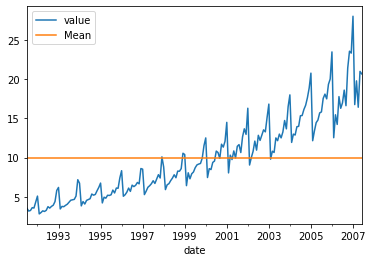

In [30]:
# Ploteamos los valores del set de entrenamiento y el modelo:
df_train.plot(kind="line", y = ["value", "Mean"]);

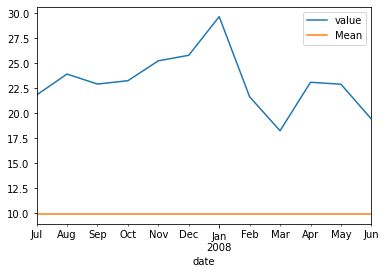

In [31]:
# Ploteamos los valores del set de testeo y el modelo

df_test.plot(kind="line", y = ["value", "Mean"]);

* ¿Cuán bien ajusta esta estimación?

Primero definimos una función que calcula el **RMSE**. 

In [32]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [33]:
model_mean_RMSE = RMSE(df_test.Mean, df_test.value)
model_mean_RMSE

13.55559205561688

In [34]:
# Guardamos el resultado en un DataFrame:
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Mean"
df_Results.loc[0, "RMSE"] = model_mean_RMSE
df_Results.head()

,Model,RMSE
0,Mean,13.555592


#### Tendencia Lineal:

Continuaremos trabajando con la tendencia lineal entre value y time, fiteando nuestro modelo de regresión lineal entre "Value" y "timeIndex". En esta práctica vamos a usar la API formula de statsmodels, pero podríamos usar cualquier otra librería para realizar la regresión por ejemplo Sklearn que ya la venimos usando.

In [35]:
model_linear = smf.ols('value ~ timeIndex', data = df_train).fit()

El primer argumento corresponde a la forma funcional de nuestra estimación. [Más detalles](http://www.statsmodels.org/dev/examples/notebooks/generated/formulas.html).

In [36]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     1104.
Date:                Fri, 27 May 2022   Prob (F-statistic):           4.48e-81
Time:                        19:35:57   Log-Likelihood:                -403.54
No. Observations:                 192   AIC:                             811.1
Df Residuals:                     190   BIC:                             817.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6940      0.286      5.921      0.000       1.130       2.258
timeIndex      0.0861      0.003     33.223      0.000       0.081       0.091
==============================================================================
Omnibus:                       58.489   Durbin-Watson:                   1.167
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.940
Skew:                           1.250   Prob(JB):                     2.80e-38
Kurtosis:                       6.920   Cond. No.                         220.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Observamos los resultados de la estimación del modelo. Vemos que la tendencia lineal es una variable significativa y que el R2 es igual a 0,853.


Veamos las predicciones del modelo sobre el set de entrenamiento:

In [37]:
df_train["LinearTrend"] = model_linear.predict(df_train.timeIndex)

Ploteamos los resultados de la predicción:

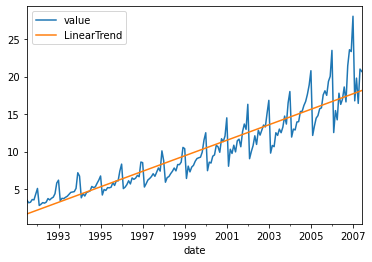

In [38]:
df_train.plot(kind = "line", y = ["value","LinearTrend"]);

Veamos las predicciones del modelo sobre el set de testeo:

In [40]:
df_test["LinearTrend"] = model_linear.predict(df_test.timeIndex)

Ploteamos los resultados de test:

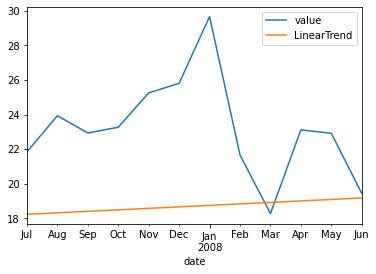

In [42]:
df_test.plot(kind = "line", y = ["value","LinearTrend"]);

Calculamos el error y añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior:

In [43]:
df_Results.loc[2, "Model"] = "LinearTrend"
df_Results.loc[2, "RMSE"] = RMSE(df_test.LinearTrend, df_test.value)
df_Results

,Model,RMSE
0,Mean,13.555592
2,LinearTrend,5.350154


#### Tendencia Cuadrática:

Continuaremos trabajando con la tendencia cuadrática entre value y time:

In [44]:
# Ahora fiteamos nuestro modelo de regresión lineal entre value y timeIndex + timeIndex_sq

model_quadratic = smf.ols('value ~ timeIndex + timeIndex_sq', data = df_train).fit()

In [45]:
# Observamos el summary del modelo:

model_quadratic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     731.3
Date:                Fri, 27 May 2022   Prob (F-statistic):           1.08e-89
Time:                        19:38:36   Log-Likelihood:                -379.59
No. Observations:                 192   AIC:                             765.2
Df Residuals:                     189   BIC:                             774.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.7416      0.377      9.915      0.000       2.997       4.486
timeIndex        0.0214      0.009      2.347      0.020       0.003       0.039
timeIndex_sq     0.0003   4.63e-05      7.318      0.000       0.000       0.000
==============================================================================
Omnibus:                       42.894   Durbin-Watson:                   1.497
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.412
Skew:                           0.910   Prob(JB):                     2.62e-27
Kurtosis:                       6.463   Cond. No.                     4.86e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Vemos que la componente cuadrática es significativa, ya que también tiene un p-valor cercano a cero y el R2 mejora a 0,886.
Veamos las predicciones del modelo sobre el set de entrenamiento:

In [47]:
df_train["QuadraticTrend"] = model_quadratic.predict(df_train[["timeIndex",\
                                                      "timeIndex_sq"]])

Ploteamos los resultados de la predicción:

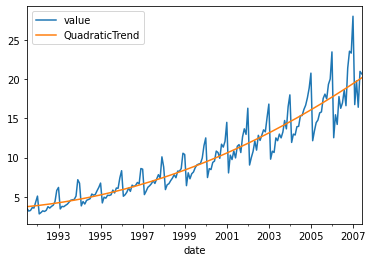

In [48]:
df_train.plot(kind = "line", y = ["value","QuadraticTrend"]);

Veamos las predicciones del modelo sobre el set de testeo:

In [49]:
df_test["QuadraticTrend"] = model_quadratic.predict(df_test[["timeIndex",\
                                                      "timeIndex_sq"]])

Ploteamos los resultados de la predicción:

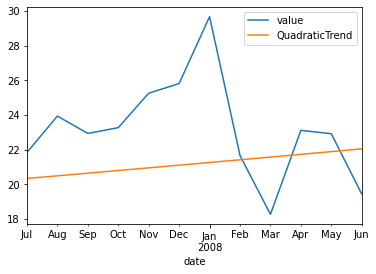

In [50]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_test.plot(kind = "line", y = ["value", "QuadraticTrend"]);

Agregamos las predicciones al DataFrame de testeo:

In [51]:
# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior
df_Results.loc[3, "Model"] = "QuadraticTrend"
df_Results.loc[3, "RMSE"] = RMSE(df_test.QuadraticTrend, df_test.value)
df_Results

,Model,RMSE
0,Mean,13.555592
2,LinearTrend,5.350154
3,QuadraticTrend,3.624616


Vemos que trabajar con un trend cuadrático mejora el RMSE, llevándolo a 3,62.

#### Tendencia con transformación logarítmica:

Analizando los datos, vemos que la varianza de la serie aumenta con el paso del tiempo. 

Veamos si una transformación logarítimica con ayuda a estabilizar la varianza:

In [52]:
df_train['log_value'] = np.log(df_train['value'])
df_test['log_value'] = np.log(df_test['value'])

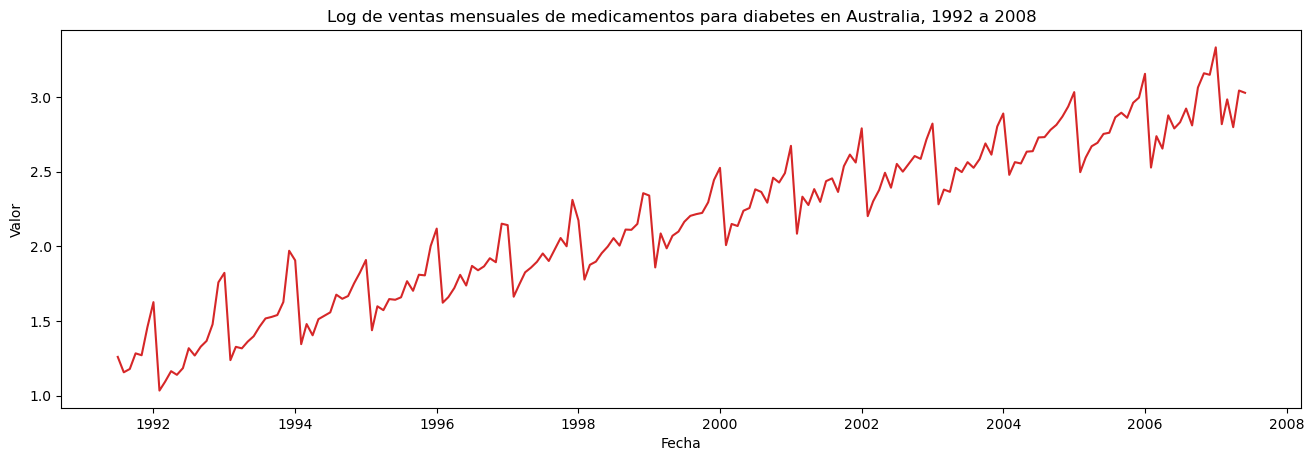

In [53]:
plot_df(df_train, x=df_train.index, y=df_train['log_value'],\
    title='Log de ventas mensuales de medicamentos para diabetes en Australia, 1992 a 2008')

Ahora fiteamos nuestro modelo de regresión lineal entre log_value y timeIndex:

In [54]:
model_log = smf.ols('log_value ~ timeIndex ', data = df_train).fit()

Veamos el summary del modelo:

In [56]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     2101.
Date:                Fri, 27 May 2022   Prob (F-statistic):          1.15e-104
Time:                        19:40:43   Log-Likelihood:                 86.148
No. Observations:                 192   AIC:                            -168.3
Df Residuals:                     190   BIC:                            -161.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2703      0.022     56.892      0.000       1.226       1.314
timeIndex      0.0093      0.000     45.835      0.000       0.009       0.010
==============================================================================
Omnibus:                        7.239   Durbin-Watson:                   1.405
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                7.331
Skew:                           0.479   Prob(JB):                       0.0256
Kurtosis:                       3.005   Cond. No.                         220.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Vemos que trabajar con la transformación logarítmica mejora la bondad de ajuste del modelo ya que el R2 ajustado es de 0,917.  

Veamos las predicciones:

In [57]:
df_train['model_log'] = model_log.predict(df_train[["timeIndex"]])
df_test['model_log'] = model_log.predict(df_test[["timeIndex"]])

Almacenamos las predicciones del modelo en el set de entrenamiento y testeo luego de haber realizado back-transformation:

In [58]:
df_train['back_model_log'] = np.exp(df_train['model_log'])
df_test['back_model_log'] = np.exp(df_test['model_log'])

In [59]:
df_test.head()

,value,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,...,May,Nov,Oct,Sep,Mean,LinearTrend,QuadraticTrend,log_value,model_log,back_model_log
date,,,,,,,,,,,,,,,,,,,,,
2007-07-01,21.834890,2007,Jul,192,36864,0,0,0,0,1,...,0,0,0,0,9.914647,18.221353,20.333919,3.083509,3.049907,21.113388
2007-08-01,23.930204,2007,Aug,193,37249,1,0,0,0,0,...,0,0,0,0,9.914647,18.307433,20.485675,3.175141,3.059176,21.309993
2007-09-01,22.930357,2007,Sep,194,37636,0,0,0,0,0,...,0,0,0,1,9.914647,18.393513,20.638107,3.132462,3.068445,21.508428
2007-10-01,23.263340,2007,Oct,195,38025,0,0,0,0,0,...,0,0,1,0,9.914647,18.479593,20.791217,3.146879,3.077714,21.708711
2007-11-01,25.250030,2007,Nov,196,38416,0,0,0,0,0,...,0,1,0,0,9.914647,18.565673,20.945004,3.228827,3.086982,21.910859


Ploteamos los resultados de la predicción en el set de entrenamiento **sin** back-transformation:


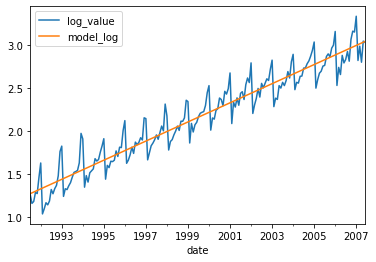

In [60]:
df_train.plot(kind = "line", y = ['log_value', 'model_log']);

Ploteamos los resultados de la predicción en el set de entrenamiento **con** back-transformation:

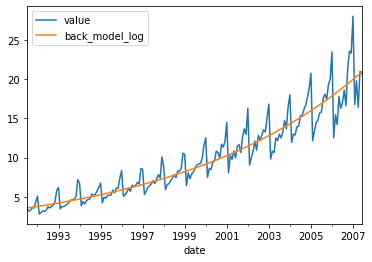

In [61]:
df_train.plot(kind = "line", y = ['value', 'back_model_log']);

Ploteamos los resultados de la predicción en el set de testeo **sin** back-transformation:

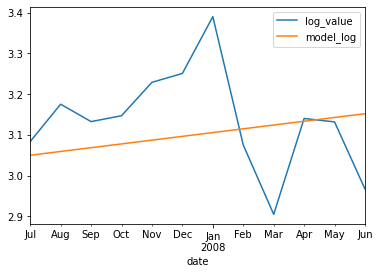

In [62]:
df_test.plot(kind = "line", y = ['log_value', 'model_log']);

Ploteamos los resultados de la predicción en el set de testeo **con** back-transformation:

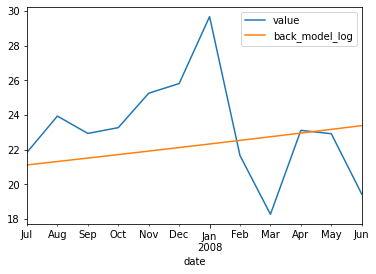

In [63]:
df_test.plot(kind = "line", y = ['value', 'back_model_log']);

In [64]:
# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior:
df_Results.loc[4, "Model"] = "Transf Log"
df_Results.loc[4, "RMSE"] = RMSE(df_test['back_model_log'], df_test['value'])
df_Results

,Model,RMSE
0,Mean,13.555592
2,LinearTrend,5.350154
3,QuadraticTrend,3.624616
4,Transf Log,3.253106


Vemos una mejoría en el RMSE con el modelo logarítmico. 

#### Tendencia con transformación logarítmica + estacionalidad mensual:

Ahora fiteamos nuestro modelo de regresión lineal entre log_value y timeIndex más las dummies de mes:

In [65]:
model_log_est = smf.ols('log_value ~ timeIndex  + Dec +Aug + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',\
                          data = df_train).fit()

In [66]:
model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     1235.
Date:                Fri, 27 May 2022   Prob (F-statistic):          3.89e-165
Time:                        19:43:00   Log-Likelihood:                 272.28
No. Observations:                 192   AIC:                            -518.6
Df Residuals:                     179   BIC:                            -476.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1232      0.017     65.773      0.000       1.090       1.157
timeIndex      0.0093   7.92e-05    117.731      0.000       0.009       0.009
Dec            0.3629      0.021     16.911      0.000       0.321       0.405
Aug            0.1357      0.021      6.320      0.000       0.093       0.178
Feb           -0.0969      0.021     -4.515      0.000      -0.139      -0.055
Jan            0.4366      0.021     20.345      0.000       0.394       0.479
Jul            0.1357      0.021      6.321      0.000       0.093       0.178
Jun            0.0702      0.021      3.271      0.001       0.028       0.113
Mar            0.0209      0.021      0.973      0.332      -0.021       0.063
May            0.0855      0.021      3.986      0.000       0.043       0.128
Nov            0.2205      0.021     10.276      0.000       0.178       0.263
Oct            0.1987      0.021      9.257      0.000       0.156       0.241
Sep            0.1350      0.021      6.290      0.000       0.093       0.177
==============================================================================
Omnibus:                        1.506   Durbin-Watson:                   1.489
Prob(Omnibus):                  0.471   Jarque-Bera (JB):                1.170
Skew:                          -0.071   Prob(JB):                        0.557
Kurtosis:                       3.355   Cond. No.                     1.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Vemos que al agregar las dummies mensuales, la bondad del modelo mejora sustancialmente. El R2 es 0.987. Por otro lado, vemos que los coeficientes de todos los meses son significativos, con excepción del mes de marzo, cuyo p-valor es de 0,332. Podríamos volver a entrenar el modelo sin el mes de marzo para ver si mejora. 

In [67]:
model_log_est = smf.ols('log_value ~ timeIndex  + Dec +Aug + Feb + Jan + Jul + Jun  + May + Nov + Oct + Sep',\
                          data = df_train).fit()

In [68]:
model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     1348.
Date:                Fri, 27 May 2022   Prob (F-statistic):          1.66e-166
Time:                        19:44:53   Log-Likelihood:                 271.77
No. Observations:                 192   AIC:                            -519.5
Df Residuals:                     180   BIC:                            -480.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1337      0.013     85.488      0.000       1.108       1.160
timeIndex      0.0093   7.92e-05    117.746      0.000       0.009       0.009
Dec            0.3524      0.019     18.968      0.000       0.316       0.389
Aug            0.1252      0.019      6.737      0.000       0.089       0.162
Feb           -0.1073      0.019     -5.776      0.000      -0.144      -0.071
Jan            0.4261      0.019     22.935      0.000       0.389       0.463
Jul            0.1253      0.019      6.738      0.000       0.089       0.162
Jun            0.0598      0.019      3.217      0.002       0.023       0.096
May            0.0751      0.019      4.042      0.000       0.038       0.112
Nov            0.2101      0.019     11.306      0.000       0.173       0.247
Oct            0.1882      0.019     10.129      0.000       0.152       0.225
Sep            0.1246      0.019      6.702      0.000       0.088       0.161
==============================================================================
Omnibus:                        1.577   Durbin-Watson:                   1.497
Prob(Omnibus):                  0.455   Jarque-Bera (JB):                1.261
Skew:                          -0.058   Prob(JB):                        0.532
Kurtosis:                       3.380   Cond. No.                         972.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Calculamos las predicciones:

In [69]:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex", \
                                              "Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])


df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex", \
                                              "Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])

Almacenamos las predicciones del modelo en el set de entrenamiento y testeo luego de haber realizado back-transformation:

In [70]:
df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])

In [71]:
df_test.head()

,value,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,...,Oct,Sep,Mean,LinearTrend,QuadraticTrend,log_value,model_log,back_model_log,model_log_est,back_model_log_est
date,,,,,,,,,,,,,,,,,,,,,
2007-07-01,21.834890,2007,Jul,192,36864,0,0,0,0,1,...,0,0,9.914647,18.221353,20.333919,3.083509,3.049907,21.113388,3.048607,21.085945
2007-08-01,23.930204,2007,Aug,193,37249,1,0,0,0,0,...,0,0,9.914647,18.307433,20.485675,3.175141,3.059176,21.309993,3.057896,21.282736
2007-09-01,22.930357,2007,Sep,194,37636,0,0,0,0,0,...,0,1,9.914647,18.393513,20.638107,3.132462,3.068445,21.508428,3.066551,21.467722
2007-10-01,23.263340,2007,Oct,195,38025,0,0,0,0,0,...,1,0,9.914647,18.479593,20.791217,3.146879,3.077714,21.708711,3.139532,23.093057
2007-11-01,25.250030,2007,Nov,196,38416,0,0,0,0,0,...,0,0,9.914647,18.565673,20.945004,3.228827,3.086982,21.910859,3.170708,23.824358


Ploteamos los resultados de la predicción en el set de entrenamiento **sin** back-transformation:

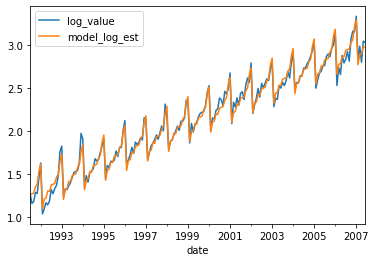

In [72]:
df_train.plot(kind = "line", y = ['log_value', 'model_log_est']);

Ploteamos los resultados de la predicción en el set de entrenamiento **con** back-transformation:

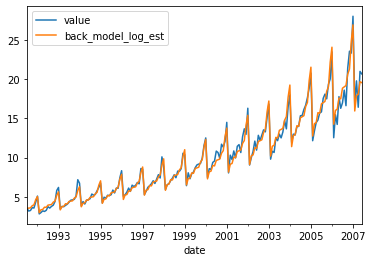

In [73]:
df_train.plot(kind = "line", y = ['value', 'back_model_log_est']);

Ploteamos los resultados de la predicción en el set de testeo **sin** back-transformation:

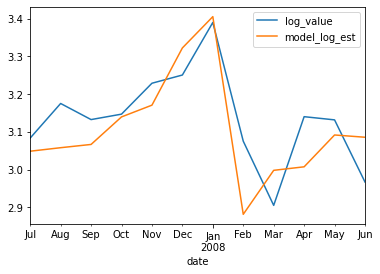

In [74]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_test.plot(kind = "line", y = ['log_value', 'model_log_est']);

Ploteamos los resultados de la predicción en el set de testeo **con** back-transformation:

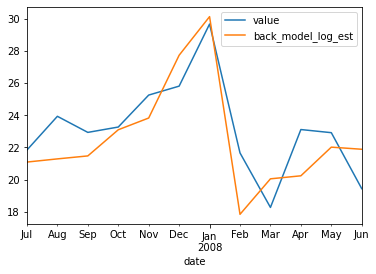

In [75]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_test.plot(kind = "line", y = ['value', 'back_model_log_est']);

In [76]:
df_Results.loc[5, "Model"] = "Transf Log + est"
df_Results.loc[5, "RMSE"] = RMSE(df_test['back_model_log_est'], df_test['value'])
df_Results

,Model,RMSE
0,Mean,13.555592
2,LinearTrend,5.350154
3,QuadraticTrend,3.624616
4,Transf Log,3.253106
5,Transf Log + est,2.01017


Vemos que al modelar la estacionalidad mensual agregando las variables dummy, nuestro modelos mejora sustancialmente, reduciéndose el RMSE de 3,25 a 2,05.

#### Single Exponential Smoothing:


El **suavizamiento exponencial simple** otorga más importancia a la información reciente y menos a la pasada. En su forma más simple podemos expresarlo como:

$$ \widehat{Y_t} =\alpha . Y_{t-1}  + (1 - \alpha ) . \widehat{Y}_{t -1} $$

Aquí el modelo es un promedio ponderado entre el valor actual y el valor anterior del modelo.
$\alpha$  se conoce como smoothing factor.

In [77]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model_exp_smoothing = SimpleExpSmoothing(df_train.value).fit(smoothing_level=0.3,\
                                                            optimized=False)

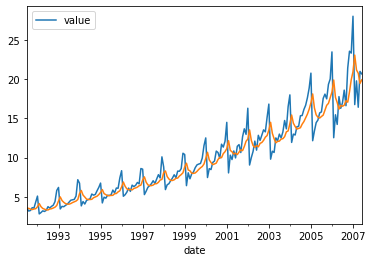

In [78]:
df_train.plot(kind = "line", y = "value")
model_exp_smoothing.fittedvalues.plot();

###### Time Series Cross Validation 

Antes de comenzar a construir un modelo, veamos primero cómo optimizar los hiperparámetros del modelo automáticamente.

¿Cómo podemos hacer para realizar validación cruzada con series de tiempo? Las series de tiempo tienen una estructura temporal y no se pueden mezclar los valores aleatoriamente en una partición mientras se conserva esta estructura. Con la aleatorización, se perderán todas las dependencias temporales entre las observaciones. Es por esto que tendremos que usar un enfoque más complicado para optimizar los parámetros del modelo. Utilizaremos es "cross validation on a rolling basis".

La idea es bastante simple: entrenamos nuestro modelo en un pequeño segmento de la serie de tiempo desde el principio hasta algunas t, hacemos predicciones para los siguientes t + n pasos y calculamos un error. Luego, expandimos nuestra muestra de entrenamiento a valor t + n, hacemos predicciones desde t + n hasta t + 2 ∗ n, y continuamos moviendo nuestro segmento de prueba de la serie de tiempo hasta que alcanzamos la última observación disponible.


Aplicamos un split entre train y test para series de tiempo:

In [79]:
from sklearn.model_selection import TimeSeriesSplit 

tscv = TimeSeriesSplit(n_splits=5)

Con fines ilustrativos, vamos a hacer un print de los elementos del set de entrenamiento y validación para cada fold:

In [80]:
for train_index, val_index in tscv.split(df_train):
    print("TRAIN:", train_index, "VAL:", val_index)

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31] VAL: [32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63] VAL: [64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87
 88 89 90 91 92 93 94 95]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95] VAL: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127]
TRAIN: [  0   1   2   3   4   5   6   7   8   9

Definimos una función que aplica time series cross validation para el modelo single exponential smoothing:

In [81]:
from sklearn.metrics import mean_squared_error

def timeseriesCVscore_exp_smoot(alpha, series):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # creamos un array de errores:
    errors = []
    
    values = series.values
    
    # instanciamos el objeto que realiza el tscv:
    tscv = TimeSeriesSplit(n_splits=5) 
    
    # Aplicamos cross validation:

    for train, test in tscv.split(values):
    
        model = SimpleExpSmoothing(values[train]).fit(smoothing_level=alpha,\
                                                             optimized=False)
        
        predictions = model.forecast(len(test))
        actual = values[test]
    
        error = mean_squared_error(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [82]:
alphas = [0.001, 0.01, 0.1, 0.2, 0.3, 0.35, 0.4, 0.5, 0.7]
errors = []

for alpha in alphas:
    error = timeseriesCVscore_exp_smoot(alpha, df_train.value)
    errors.append(error)

print('Alpha óptimo:', alphas[np.argmin(errors)])

Alpha óptimo: 0.5


In [83]:
# Entrenamos el modelo optimizado:

model_exp_smoothing = SimpleExpSmoothing(df_train.value).fit(smoothing_level=alphas[np.argmin(errors)],\
                                                             optimized=False)

In [84]:
df_test["Simple_Smoothing"] = model_exp_smoothing.forecast(12)
df_test.head()

,value,year,month,timeIndex,timeIndex_sq,Aug,Dec,Feb,Jan,Jul,...,Sep,Mean,LinearTrend,QuadraticTrend,log_value,model_log,back_model_log,model_log_est,back_model_log_est,Simple_Smoothing
date,,,,,,,,,,,,,,,,,,,,,
2007-07-01,21.834890,2007,Jul,192,36864,0,0,0,0,1,...,0,9.914647,18.221353,20.333919,3.083509,3.049907,21.113388,3.048607,21.085945,20.192834
2007-08-01,23.930204,2007,Aug,193,37249,1,0,0,0,0,...,0,9.914647,18.307433,20.485675,3.175141,3.059176,21.309993,3.057896,21.282736,20.192834
2007-09-01,22.930357,2007,Sep,194,37636,0,0,0,0,0,...,1,9.914647,18.393513,20.638107,3.132462,3.068445,21.508428,3.066551,21.467722,20.192834
2007-10-01,23.263340,2007,Oct,195,38025,0,0,0,0,0,...,0,9.914647,18.479593,20.791217,3.146879,3.077714,21.708711,3.139532,23.093057,20.192834
2007-11-01,25.250030,2007,Nov,196,38416,0,0,0,0,0,...,0,9.914647,18.565673,20.945004,3.228827,3.086982,21.910859,3.170708,23.824358,20.192834


In [85]:
model_simp_smo_RMSE = RMSE(df_test["Simple_Smoothing"], df_test.value)
model_simp_smo_RMSE

4.110187300262552

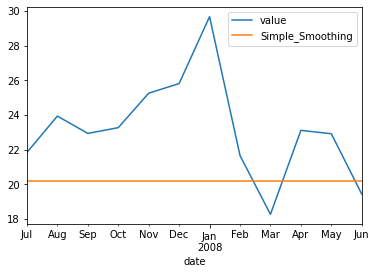

In [86]:
df_test.plot(kind="line", y = ["value", "Simple_Smoothing"]);

In [87]:
# Calculamos el RMSE y almacenamos los resultados
df_Results.loc[6, "Model"] = "Simple Smoothing"
df_Results.loc[6, "RMSE"] = RMSE(df_test["Simple_Smoothing"], df_test.value)
df_Results

,Model,RMSE
0,Mean,13.555592
2,LinearTrend,5.350154
3,QuadraticTrend,3.624616
4,Transf Log,3.253106
5,Transf Log + est,2.01017
6,Simple Smoothing,4.110187


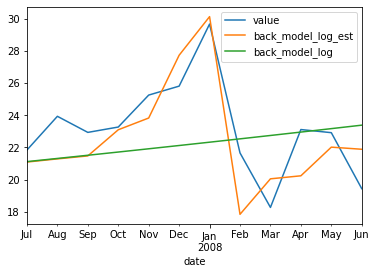

In [89]:
# Ploteamos las mejores estimaciones 
df_test.plot(kind = "line", y = ["value", "back_model_log_est",\
                                                 "back_model_log"]);

Conclusiones :

Podemos descomponer una serie de tiempo en:

- **Tendencia**
- **Estacionalidad**
- **Ciclos**
- **Componente aleatoria**

De manera aditiva, podemos decir entonces que: 

$$ y_t = T_t + S_t + C_t + \varepsilon_t. $$

- Para modelar la tendencia y la estacionalidad podemos usar dummies de tiempo y estacionales. 
